# 1 - Listado de variables y selección

## Entrada
* Manufacturer: Marca / fabricante del equipo
* Model Name: Nombre / número de modelo del equipo
* Category: Tipo de notebook
* Screen Size: Tamaño diagonal de la pantalla en pulgadas
* Screen Type: Resolución y tipo de panel
* CPU: Modelo de procesador
* RAM: Capacidad de memoria
* Storage: Tipo y tamaño de almacenamiento interno
* GPU: Tipo y modelo de procesador de gráficos
* OS: Sistema operativo
* Weight: Peso

## Salida
* Price: Será reducida con rangos a valores "bajo", "medio" o "alto"

## No utilizadas
* OS Version: No usada debido a su gran cantidad de nulos y presunta poca importancia

# 2 - Análisis detallado de un conjunto de variables


In [27]:
import pandas as pd

In [28]:
laptops_train = pd.read_csv('laptops_train.csv')
laptops_test = pd.read_csv('laptops_test.csv')

In [29]:
print("Entries de train: "+str(len(laptops_train)))
print("Entries de test: "+str(len(laptops_test)))

Entries de train: 977
Entries de test: 325


In [30]:
laptops_train.isnull().sum()

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
 Storage                      0
GPU                           0
Operating System              0
Operating System Version    136
Weight                        0
Price                         0
dtype: int64

In [31]:
laptops_test.isnull().sum()

Manufacturer                 0
Model Name                   0
Category                     0
Screen Size                  0
Screen                       0
CPU                          0
RAM                          0
 Storage                     0
GPU                          0
Operating System             0
Operating System Version    34
Weight                       0
Price                        0
dtype: int64

In [32]:
laptops_train

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,10,4.42kg,24897600.00
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,10,1.95kg,10492560.00
974,Asus,Rog Strix,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,10,2.73kg,18227710.80
975,HP,Probook 450,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,10,2.04kg,8705268.00


In [33]:
# Renombre de las series
new_col_names = {
    "Manufacturer":"manufacturer",
    "Model Name":"model",
    "Category":"category",
    "Screen Size":"screen_size",
    "Screen":"resolution",
    "CPU":"cpu",
    "RAM":"ram",
    " Storage":"storage", # la string original tiene el espacio, sin eso no lo cambia
    "GPU":"gpu",
    "Operating System":"os",
    #"Operating System Version":"os_version",
    "Weight":"weight",
    "Price":"price"
}

laptops_train = laptops_train.rename(columns=new_col_names).drop(columns="Operating System Version")
laptops_test = laptops_test.rename(columns=new_col_names).drop(columns="Operating System Version")

In [34]:
laptops_train

,manufacturer,model,category,screen_size,resolution,cpu,ram,storage,gpu,os,weight,price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,16037611.20
...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,4.42kg,24897600.00
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,1.95kg,10492560.00
974,Asus,Rog Strix,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,2.73kg,18227710.80
975,HP,Probook 450,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,2.04kg,8705268.00


In [35]:
# Conversión de la variable de salida de rupias a dólares, tomando como base la cotización del 28/03/2023, según la última actualización del dataset
# Se dividió por 100 el valor obtenido debido a que los precios convertidos con la cotización de referencia se encontraban fuera del rango esperado
# Cotización: 1 INR = 0.0001217 USD


cotizacion = 0.0001217

def convertir_precio(precio):
    return int(precio * cotizacion)

laptops_train["price"] = laptops_train["price"].apply(convertir_precio)
laptops_test["price"] = laptops_test["price"].apply(convertir_precio)

In [36]:
laptops_train

,manufacturer,model,category,screen_size,resolution,cpu,ram,storage,gpu,os,weight,price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1449
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,972
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,622
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2745
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1951
...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,4.42kg,3030
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,1.95kg,1276
974,Asus,Rog Strix,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,2.73kg,2218
975,HP,Probook 450,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,2.04kg,1059


In [53]:
laptops_test

,manufacturer,model,category,screen_size,resolution,cpu,ram,storage,gpu,os,weight,price
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",1366x768,Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,2.04kg,626
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,2.99kg,1892
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,12GB,512GB SSD,Intel HD Graphics 620,Windows,2.19kg,1405
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.2kg,1293
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",Full HD 1920x1080,AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows,2.2kg,594
...,...,...,...,...,...,...,...,...,...,...,...,...
320,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,"14.0""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.8kg,690
321,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,"13.3""",IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows,1.3kg,1622
322,Lenovo,IdeaPad 100S-14IBR,Notebook,"14.0""",1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows,1.5kg,247
323,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,"15.6""",1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows,2.19kg,826


In [37]:
import matplotlib as plt
import plotly.express as px

## Variable de salida

In [38]:
px.histogram(laptops_train, x="price")

In [39]:
px.histogram(laptops_train, x="price", range_x=[0, 3800])

In [40]:
px.box(laptops_train, x="price")

In [41]:
laptops_train["price"].describe()

count     977.000000
mean     1218.808598
std       767.490421
min       207.000000
25%       648.000000
50%      1037.000000
75%      1596.000000
max      6600.000000
Name: price, dtype: float64

Se puede apreciar como la variable de salida tiene una forma de campana gaussiana (buscar forma estadísticamente correcta de decir que está tirada para la izquierda). A su vez se puede ver como existen valores anómalos y aberrantes en los rangos superiores del dataset.

## Variables de entrada

### Manufacturer

In [42]:
px.box(laptops_train,x="manufacturer", y="price")

### Model

In [43]:
px.box(laptops_train,x="model",y="price", height=800)

### Category

In [44]:
px.box(laptops_train, x="category", y="price")

### Screen size

In [45]:
px.box(laptops_train, x="screen_size", y="price")

### Resolution

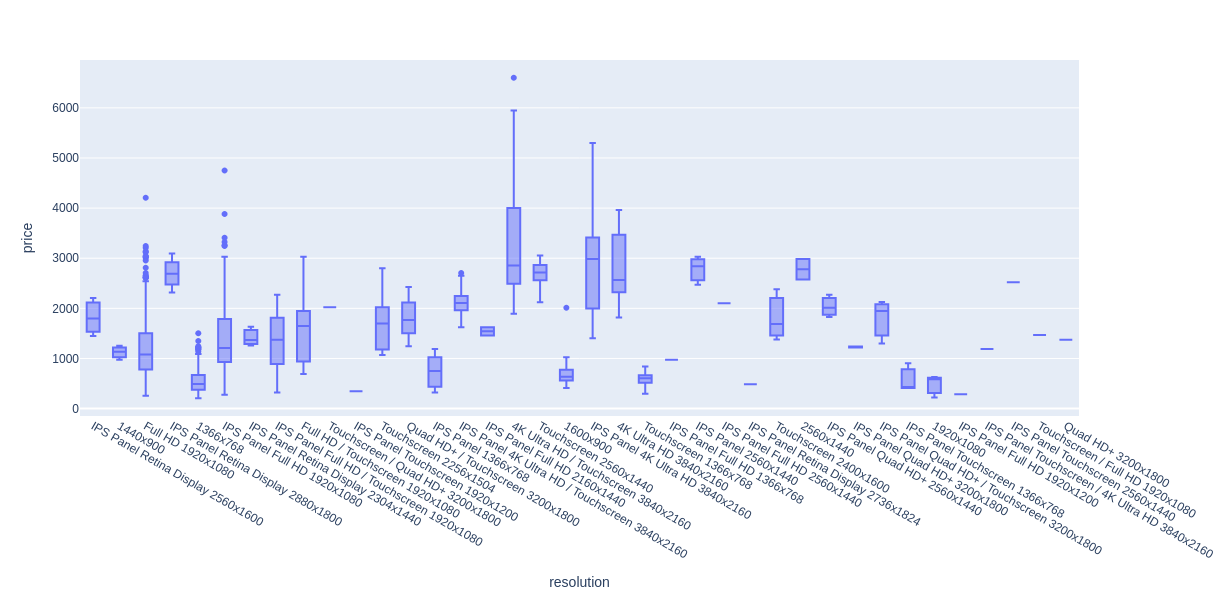

In [46]:
px.box(laptops_train, x="resolution", y="price", height=600)

### CPU

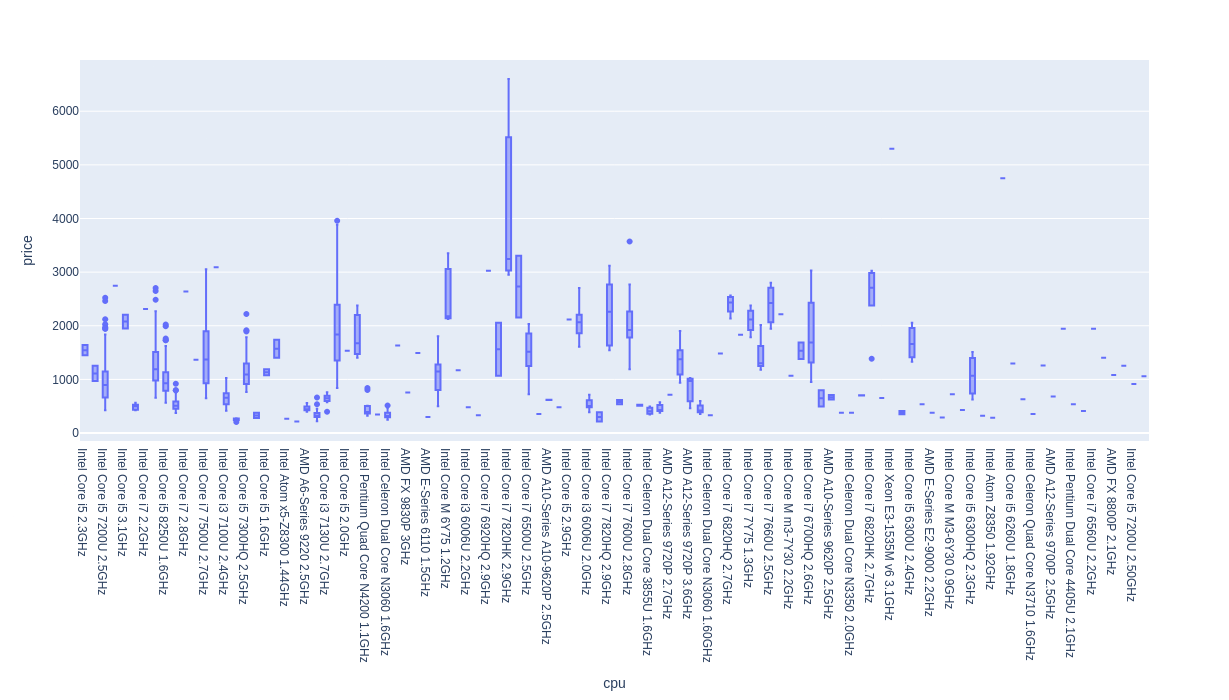

In [47]:
px.box(laptops_train, x="cpu", y="price", height=700)

### RAM

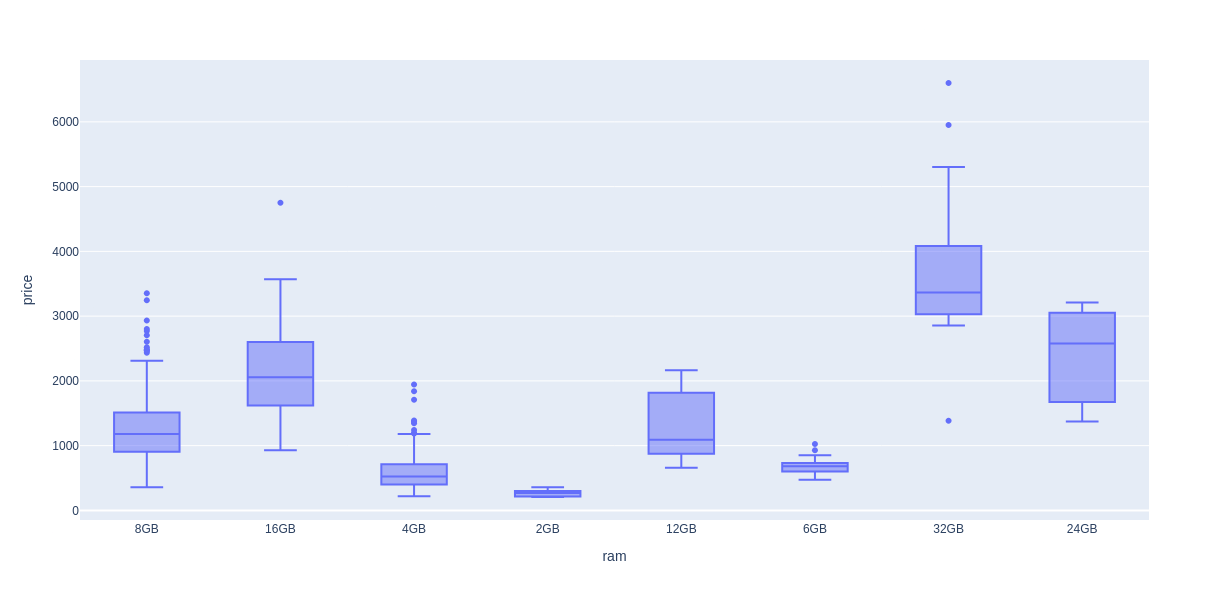

In [48]:
px.box(laptops_train, x="ram", y="price", height=600)

### Storage

In [49]:
px.scatter(laptops_train, x="storage", y="price", height=600)

### GPU

In [50]:
px.scatter(laptops_train, x="gpu", y="price", height=600)

### OS

In [51]:
px.box(laptops_train, x="os", y="price", height=600)

### Weight

In [52]:
px.scatter(laptops_train, x="weight", y="price")

## Listado de dudas/preguntas para el proveedor del dataset

* De que fuentes provienen estos precios? y que metodos fueron utilizados para recolectarlos?
* Porque la columna de SO Type tiene tantos valores nulos?
* Pensas que el tipo de SO afecta al precio?
* Pensas que existen otros factores que afecten el precio de una laptop? como serían el material de chasis, distribución de teclado, etc.
* Cual crees que es la variable que mas afecta al precio de una laptop?
* Omitiste alguna variable al creear el dataset?